### Based on: Building makemore - Part 4 - Becoming a Backprop Ninja (https://github.com/karpathy/nn-zero-to-hero)
> I implemented all the excerices from  https://www.youtube.com/watch?v=q8SA3rM6ckI. 

- ###### I fit randomly generated data
- ###### I use a slightly different MLP architecture with one output neuron
- ###### I use Binary Crossentropy as loss function

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
num_examples = 1000
num_features = 3

g = torch.Generator().manual_seed(2147483647)
xtrain = torch.randn(num_examples,num_features,generator=g) # random data
y0 = torch.zeros(int(num_examples/2))
y1 = torch.ones(int(num_examples/2))
shuffle = torch.randperm(num_examples,generator=g) 
ytrain = torch.cat((y0,y1),dim=0)[shuffle] # random labels
xtrain.shape, ytrain.shape

(torch.Size([1000, 3]), torch.Size([1000]))

In [3]:
# validation set
val_examples = 100

g = torch.Generator().manual_seed(0) # diaforetiko seed giana parw diaforetika data
xval = torch.randn(val_examples,num_features,generator=g) # random test data

val_y0 = torch.zeros(int(val_examples/2))
val_y1 = torch.ones(int(val_examples/2))
shuffle = torch.randperm(val_examples,generator=g) 
yval = torch.cat((val_y0,val_y1),dim=0)[shuffle] # random labels 
xval.shape, yval.shape

(torch.Size([100, 3]), torch.Size([100]))

In [4]:
# Neural Net parameters
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
# Layer 1
W1 = torch.randn(num_features,n_hidden,generator=g) * (5/3) / (num_features**0.5)  # first layer weights
b1 = torch.randn(n_hidden, generator=g) * 0.1 # first layer biases # just for fun, einai perito logw tou BN
# Layer 2
W2 = torch.randn(n_hidden,1,generator=g) * 0.1 # output layer weights
b2 = torch.randn(1,generator=g) * 0.1 # output layer biases
# BatchNorm parameters
bngain = torch.randn((1,n_hidden))*0.1 + 1 # Wraio Kolpo -> einai konta sto 1
bnbias = torch.randn((1,n_hidden))*0.1

# karpathy note:
  # Note: I am initializating many of these parameters in non-standard ways
  # because sometimes initializating with e.g. all zeros could mask an incorrect
  # implementation of the backward pass

# bnmean_running = torch.zeros((1,n_hidden))
# bnstd_running = torch.ones((1,n_hidden))

parameters = [W1, b1, W2, b2, bngain, bnbias] 
model_complexity = sum(p.nelement() for p in parameters) # i measure model complexity just as the number of parameters
print(model_complexity)
# so that i can run backbrop
for p in parameters:
  p.requires_grad = True

701


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
epochs = 200000
batch_size = 32
n = batch_size # a shorter variable for convinience
# construct a mini-batch
ix = torch.randint(0,xtrain.shape[0],(batch_size,))
xb, yb = xtrain[ix], ytrain[ix]
lossi = []

In [7]:
# logits_max = logits.view(-1).max()
# norm_logits = logits - logits_max
# logit = norm_logits[0]
# sigmoid_den = (1 + (-norm_logits).exp())
# prob = sigmoid_den ** -1
# prob = prob.view(-1)
# loss = - (yb * prob.log() + (1-yb) * (1-prob).log() ).mean()
# print(loss)
# loss.log10().item(), lossi[0]

# # ---------------------------------------------
# # Auta ta 2 einai to idio pragma - > mono gia ena stoixeio... gia dianisma prob den einai to idio!!!

# # Prepei na iliopoiisw ti sigmoid prwta kai meta to ylog(y_hat) + (1-y)log(1-y_hat)
# logprob = prob.log()
# loss = - (yb * logprob).mean()
# print(loss)
# loss.log10().item(), lossi[0] 

### Important Note
- ##### TO LOSS PREPEI NA GINEI: -(pred.log() * y + (1-y) * (1-pred).log()).mean()
- ##### ENAI LATHOS TO yb * logprob

In [7]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
# Linear layer 1
hprebn = xb @ W1 + b1

# BatchNorm layer
bnmeani = 1/n * hprebn.sum(dim=0,keepdims=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(dim=0,keepdims=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# binary cross entropy loss (same as F.binary_cross_entropy_with_logits(logits, Yb))
sigmoid_den = 1 + (-logits).exp() # paronomastis tis sigmoid
probs = sigmoid_den ** -1
probs = probs.view(-1)
term1 = probs.log() * yb
term2 = (1-probs).log() * (1-yb)
loss = -(term1 + term2).mean()

# Pytorch backward pass
for p in parameters:
  p.grad = None
  #logprobs, norm_logits
for t in [term1,term2, probs, sigmoid_den, # afaik there is no cleaner way
        logits, h, hpreact, bnraw, bnvar_inv, bnvar, 
        bndiff2, bndiff, hprebn, bnmeani]:
  t.retain_grad()
loss.backward()
loss

tensor(0.6729, grad_fn=<NegBackward0>)

In [8]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# gia loss = -(yb*logprobs).mean() #-> to dnorm_logits edw vgainei 0.46 enw prepei na einai konta sto 0

# dlogprobs = torch.zeros_like(logprobs) + yb * (-1.0/n)
# dprobs = (1.0 / probs) * dlogprobs.view(dlogprobs.shape[0],1)
# dsigmoid_den = -sigmoid_den**-2 * dprobs

# Gia loss = -(probs.log()*y + (1-y)*(1-probs).log()).mean()

dterm1 = torch.zeros_like(term1) - (1.0/n)
dterm2 = torch.zeros_like(term2) - (1.0/n)
dprobs = (1.0/probs) * yb * dterm1
dprobs += -(1.0/(1-probs)) * (1-yb) * dterm2
dsigmoid_den = (-sigmoid_den**-2) * dprobs.view(-1,1) # undo to view(-1), to kanw (32,1) apo (32)
dlogits = -((-logits).exp()) * dsigmoid_den
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(dim=0,keepdims=True)
dbnbias = dhpreact.sum(dim=0,keepdims=True) 
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff*dbnraw).sum(dim=0,keepdims=True)
dbndiff = bnvar_inv * dbnraw
dbnvar = -(0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2
dbnmeani = (-1.0 * dbndiff).sum(dim=0,keepdims=True) # or (-torch.ones_like(bndiff) * dbndiff).sum(dim=0) = (-dbndiff).sum(dim=0)
dhprebn = dbndiff.clone()
dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani
dW1 = xb.T @ dhprebn
db1 = dhprebn.sum(dim=0)

cmp('term1', dterm1, term1)
cmp('term2', dterm2, term2)
# cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('sigmoid_den', dsigmoid_den, sigmoid_den)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

term1           | exact: True  | approximate: True  | maxdiff: 0.0
term2           | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
sigmoid_den     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0
bnvar           | exact: True  | approximate: True  | maxdiff: 0.0
bndiff2         | exact: True  | approximate: True  | maxdiff:

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------
### The following cells contain Notes and intermiediate results used for calculating many of the above expressions

In [36]:
# dloprobs
# loss = - 1/3 * (a + b + c) * yb = -1/3a*yb - 1/3b*yb - 1/3c*yb
# dloss/da  = -1/3 * yb
# sti geniki periptosi dloss/da = yb * 1/n

In [ ]:
# dprobs
# y = log(x)
# dy/dx = 1/x - > local derivative 1.0/ probs, to view einai gia na kanw undo to view(-1)!
# 1.0/ probs * dlogprobs.view(dlogprobs.shape[0],1)

In [ ]:
# dsigmoid_den
# probs = 1/ sigmoid_den
# dprobs/dsigmoid_den = -(1/sigmoid_den)**2 -> local derivative

In [ ]:
# dnorm_logits
# y = 1 + e**(-x)
# dy/dx = -e**(-x) -> local derivative

In [ ]:
# dlogit_maxes
# dnorm_logit/dlogit_maxes = -1.0 - > local derivative
# logits.shape = (32,1) , logits_maxes.shape = (1,1)
# kanonika tha itan -1.0 * dnorm_logits, alla epeidei dnorm_logits.shape = (32,1) 
# enw egw thelw dlogit_maxes.shape == logit_maxes.shape = (1,1)
# to logit_maxes xrisimopoieitai polles fores gia oles tis grammes tou logits -> broadcasting
# otan kati (enas komvos sto graph) xrisimopoieitai polles fores 
# sto backprop ta grad tha athroizontai (sum) gia kathe branch
# gi auto pairnw sum kata grammes me keepdim wste na parw (1,1)
# dnorm_logits = (-1.0 * dnorm_logits.sum(0,keepdim=True))

# dlogit_maxes = 0.3611 EPREPE NA EINAI POLI KONTA STO 0.... kati kanw lathos?? 
# mipws den xreiazetai katholou to step me to normalization?

In [ ]:
# dlogits

# dlogits = 1 - > local derivative
# alla epeidi logit_maxes = f(logits) exw kai deutero branch sto logits 
# kai auti den einai i teliki derivative gia to logits

# c1 = a1 - b
# c2 = a2 - b
# c3 = a3 - b

# to b einai to max kai ginetai broadcast kata grammmes gi auto kanw sum(dim=0) sto dlogit_maxes
# c1 = a1 - b

# gia to max to local derivative einai 1 gia to mono gia to stoixeio max
# xrisimopoiw to logits.max(0).indices gia to index tou max kai ftiaxnw ena dianisma stili wste na pol/stei me to dlogit_maxes
# F.one_hot.shape = (32,1) , dlogit_maxes.shape = (1,1) kai ginetai broadcasting swsta! -> to logit_maxes antigrafetai kata grammes...

In [ ]:
# bndiff2 
# a11 a12
# a21 a22
# ---->
# b1 b2 , where
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a12 + a22)
# to local derivative einai 1/(n-1) gia kathe a
# the derivative of b1 has to flow through the columns of a scaled me to 1/(n-1)

In [ ]:
# dhprebn
# opws kai to dbndiff2 prepei na kanw flow to gradient kata grammes epi to scale

### End of cells containing Notes
### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# sigmoid_den = 1 + (-logits).exp()
# probs = sigmoid_den ** -1
# probs = probs.view(-1)
# term1 = probs.log() * yb
# term2 = (1-probs).log()* (1-yb)
# loss = -(term1 + term2).mean()

# now:
loss_fast = F.binary_cross_entropy_with_logits(logits.view(-1), yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

0.6728731989860535 diff: -5.960464477539063e-08


In [19]:
# backward pass
dlogits = F.sigmoid(logits).view(-1) # ta probs....
dlogits = (dlogits - yb).view(-1,1)
dlogits /= n
cmp('logits', dlogits, logits) 

# d/dx(y*log(x) + (1-y)log(1-x)) = - (x - y) / (1-x)*x
# dloss/dlogits = dloss/probs * dprobs/dlogits
# dloss/dprobs = dprobs = (probs - yb) / (probs * (1-probs)), apo tin apo panw sxesi (WOlfram alpha)
# dprobs/dlogits = sigmoid' = s*(1-s) = probs * (1-probs)
# An ta pol/sw auta aplopoiointai ola kai menei mono (probs-yb) to scalarw /n epeidi eixa to .mean()
# to view einai gia na ksanapaw se shape [32, 1] apo [32] (epd eixa probs.view(-1))

logits          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [11]:
logits.view(-1), dlogits.view(-1)*n, yb

(tensor([-0.4334, -0.4425,  0.2401, -0.5814, -0.0443, -0.2771,  0.0244, -0.2647,
          0.1349,  0.1487,  0.0642, -0.0462,  0.3320,  0.5255,  0.5218,  0.1915,
         -0.6503,  0.2971, -0.0056,  0.2296, -0.0087, -0.5033, -0.0928,  0.1861,
         -0.5740, -0.7704, -0.8233, -0.9068, -0.4128,  0.4073, -0.8394,  0.0081],
        grad_fn=<ViewBackward0>),
 tensor([-0.6067, -0.6089, -0.4403,  0.3586,  0.4889, -0.5688,  0.5061, -0.5658,
          0.5337,  0.5371, -0.4840,  0.4884,  0.5823,  0.6284, -0.3724, -0.4523,
          0.3429,  0.5737, -0.5014,  0.5572,  0.4978,  0.3768,  0.4768,  0.5464,
          0.3603,  0.3164, -0.6949, -0.7124,  0.3982,  0.6004, -0.6983,  0.5020],
        grad_fn=<MulBackward0>),
 tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.]))

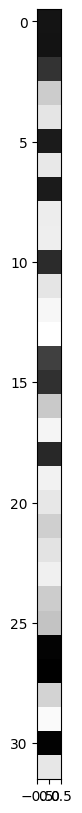

In [12]:
plt.figure(figsize=(8,10))
plt.imshow(dlogits.detach(), cmap='gray')

In [13]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(dim=0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [20]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbnvar_inv = (bndiff*dbnraw).sum(dim=0,keepdims=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar = -(0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
# dbndiff += 2 * bndiff * dbndiff2
# dbnmeani = (-1.0 * dbndiff).sum(dim=0,keepdims=True) # or (-torch.ones_like(bndiff) * dbndiff).sum(dim=0) = (-dbndiff).sum(dim=0)
# dhprebn = dbndiff.clone()

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(dim=0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(dim=0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [15]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 100]),
 torch.Size([1, 100]),
 torch.Size([1, 100]),
 torch.Size([32, 100]),
 torch.Size([100]))

In [23]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# Neural Net parameters
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
# Layer 1
W1 = torch.randn(num_features,n_hidden,generator=g) * (5/3) / (num_features**0.5)  # first layer weights
b1 = torch.randn(n_hidden, generator=g) * 0.1 # first layer biases # just for fun, einai perito logw tou BN
# Layer 2
W2 = torch.randn(n_hidden,1,generator=g) * 0.1 # output layer weights
b2 = torch.randn(1,generator=g) * 0.1 # output layer biases
# BatchNorm parameters
bngain = torch.randn((1,n_hidden))*0.1 + 1 # Wraio Kolpo -> einai konta sto 1
bnbias = torch.randn((1,n_hidden))*0.1

parameters = [W1, b1, W2, b2, bngain, bnbias] 
model_complexity = sum(p.nelement() for p in parameters) # i measure model complexity just as the number of parameters
# so that i can run backbrop
for p in parameters:
  p.requires_grad = True
  
epochs = 200000
batch_size = 32
n = batch_size # a shorter variable for convinience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  for i in range(epochs):
    ix = torch.randint(0,xtrain.shape[0],(batch_size,))
    xb, yb = xtrain[ix], ytrain[ix]

    # forward pass
    # Linear layer
    hprebn = (xb @ W1) + b1
    # BatchNorm layer
    # ---------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # ---------------------------------------------------------------
    # Non-Linearity
    h = torch.tanh(hpreact)
  #   h.retain_grad() # gia na borw na kanw h.grad
    logits = (h @ W2) + b2
    loss = F.binary_cross_entropy_with_logits(logits.view(-1),yb) # mallon pio numericaly stable?

    # backward pass 
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.sigmoid(logits).view(-1)
    dlogits = (dlogits - yb).view(-1,1)
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(dim=0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(dim=0,keepdims=True)
    dbnbias = dhpreact.sum(dim=0,keepdims=True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(dim=0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(dim=0))
    # 1st layer
    dW1 = xb.T @ dhprebn
    db1 = dhprebn.sum(dim=0)

    grads = [dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.09 # decay the lr?
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    #track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i>=100:
  #     break

      0/ 200000: 0.6906
  10000/ 200000: 0.6768
  20000/ 200000: 0.6921
  30000/ 200000: 0.6807
  40000/ 200000: 0.7058
  50000/ 200000: 0.5915
  60000/ 200000: 0.7081
  70000/ 200000: 0.6851
  80000/ 200000: 0.6553
  90000/ 200000: 0.6856
 100000/ 200000: 0.6559
 110000/ 200000: 0.5940
 120000/ 200000: 0.7083
 130000/ 200000: 0.6186
 140000/ 200000: 0.6467
 150000/ 200000: 0.6576
 160000/ 200000: 0.6764
 170000/ 200000: 0.6135
 180000/ 200000: 0.7151
 190000/ 200000: 0.6758


In [22]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(3, 100)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(100,)          | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-09
(100, 1)        | exact: True  | approximate: True  | maxdiff: 0.0
(1,)            | exact: True  | approximate: True  | maxdiff: 0.0
(1, 100)        | exact: True  | approximate: True  | maxdiff: 0.0
(1, 100)        | exact: True  | approximate: True  | maxdiff: 0.0


In [24]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  hpreact = xtrain @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [25]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtrain, ytrain),
    'val': (xval,yval)
  }[split]
  hpreact = x @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, 1)
  loss = F.binary_cross_entropy_with_logits(logits.view(-1), y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.6148810982704163
val 0.7544530630111694


### Results:

- ###### Me loss.backward:
    - train: 0.6025290489196777
    - val: 0.7441983819007874
- ###### Manual backprop:
    - train: 0.6148810982704163
    - val: 0.7544530630111694
    
###### NOT BAD!

In [13]:
# me loss.backward:
# train 0.6025290489196777
# val 0.7441983819007874

# manual backprop:
# train 0.6148810982704163
# val 0.7544530630111694

# NOT BAD!!!